# Race NOT Included

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

#loading data
data = pd.read_csv('/Users/yunjuha/Desktop/ML-DXA-BIS/Data Files/ML-DXA-BIS_Combined_Data.csv')
df = pd.DataFrame(data)

#TRANSFORMING THE TARGETS
df['tjumppownums'] = np.log(df['jumppownums'] + 0.1)
df['tCOMB4IMaxGrip'] = np.sqrt(df['COMB4IMaxGrip'])

#dropping columns
column_to_drop = ['M2ID', 'MIDUSID', 'SAMPLMAJ', 'Height.cm.', 'Weight.kg.', 'Age.years.', 'TBW.litres.', 'ECF.litres.', 'ICF.litres.']
df = df.drop(column_to_drop, axis=1)

df = df.drop('COMB1PF7A', axis=1)

In [9]:
#number of individuals before NA is removed
print(len(df))

544


In [10]:
#total number of individuals when race is excluded
df = df.dropna()
print(len(df))

490


# LASSO

In [11]:
#LASSO Function

def train_test_lasso(df, feature_columns, target_column, remove_by=40, test_size=0.2, random_state=42):
    original_size = len(df)
    r_squared_data = []

    while len(df) >= remove_by:
        columns = feature_columns + [target_column]
        X = df[columns]
        y = X.pop(target_column)
        
        #dividing into train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        #scaling features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        lasso_model = Lasso()

        #our parameter grid for hyperparameter tuning
        alphas = np.logspace(-4, 0, 100)
        max_iters = [10000, 20000, 30000, 50000]
        param_grid = {'alpha': alphas, 'max_iter': max_iters}

        #doing grid search with cross-validation to find the best hyperparameters
        grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)

        best_alpha = grid_search.best_params_['alpha']
        best_max_iter = grid_search.best_params_['max_iter']

        #print("Best Alpha:", best_alpha)
        #print("Best Max Iterations:", best_max_iter)

        #running the model using the best hyperparameters
        best_lasso_model = Lasso(alpha=best_alpha, max_iter=best_max_iter)
        best_lasso_model.fit(X_train_scaled, y_train)

        #TRAINING
        y_pred_train = best_lasso_model.predict(X_train_scaled)
        r2_train = metrics.r2_score(y_train, y_pred_train)
        #print("Training R2: ", r2_train)

        #TESTING
        y_pred = best_lasso_model.predict(X_test_scaled)
        r2_test = metrics.r2_score(y_test, y_pred)
        #print("Testing R2: ", r2_test)

        r_squared_data.append({'Number of Individuals': len(df), 'Training R-squared': r2_train, 'Testing R-squared': r2_test})

        #removing 40 individuals for the next iteration
        indices_to_remove = df.sample(n=remove_by, random_state=random_state).index
        df = df.drop(indices_to_remove)

    #table of R-squared values
    r_squared_table = pd.DataFrame(r_squared_data)
    print("\nR-squared Values:")
    print(r_squared_table)

    #plot
    plt.figure(figsize=(10, 6))
    plt.plot(r_squared_table['Number of Individuals'], r_squared_table['Training R-squared'], label='Training R-squared')
    plt.plot(r_squared_table['Number of Individuals'], r_squared_table['Testing R-squared'], label='Testing R-squared')
    plt.xlabel('Number of Individuals')
    plt.ylabel('R-squared')
    plt.title('Training and Testing R-squared vs Number of Individuals')
    plt.legend()
    plt.show()
    

## DXA: Handgrip Strength (ARMS)

LASSO: DXA Model, Handgrip Strength (Arms)



R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.531311           0.389480
1                     450            0.536489           0.430963
2                     410            0.531786           0.472472
3                     370            0.493657           0.621037
4                     330            0.497960           0.475240
5                     290            0.461873           0.506457
6                     250            0.473613           0.408621
7                     210            0.413261           0.514552
8                     170            0.426826           0.275744
9                     130            0.438304           0.229946
10                     90            0.374399           0.516531
11                     50            0.474271           0.082646


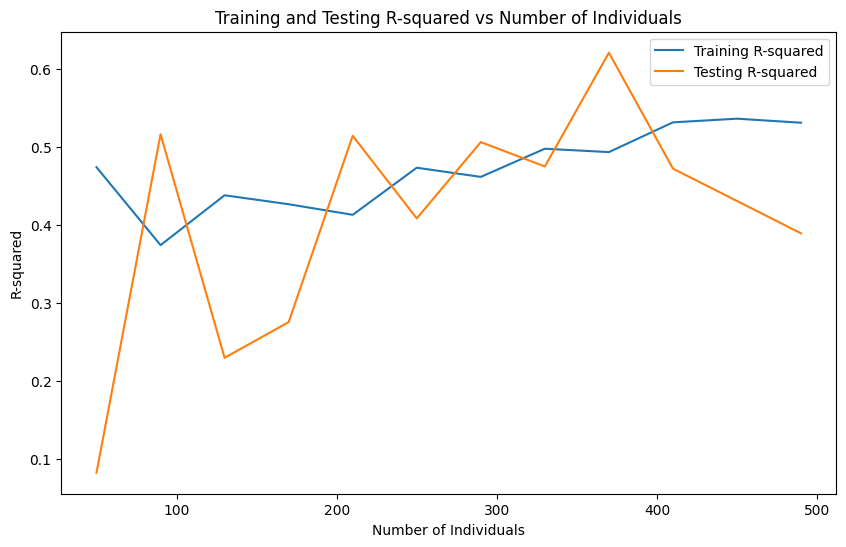

In [12]:
print("LASSO: DXA Model, Handgrip Strength (Arms)")

train_test_lasso(df, ['COMB4DALM', 'COMB4DABM', 'COMB4DAFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD'], 'tCOMB4IMaxGrip')

## DXA: Handgrip Strength (TOTAL BODY)

LASSO: DXA Model, Handgrip Strength (TB)



R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.519670           0.418677
1                     450            0.526148           0.423322
2                     410            0.519203           0.465900
3                     370            0.480259           0.630517
4                     330            0.487255           0.448616
5                     290            0.435020           0.477736
6                     250            0.470673           0.339162
7                     210            0.432044           0.464215
8                     170            0.399225           0.174083
9                     130            0.437459           0.366792
10                     90            0.412535           0.354433
11                     50            0.592801          -0.112375


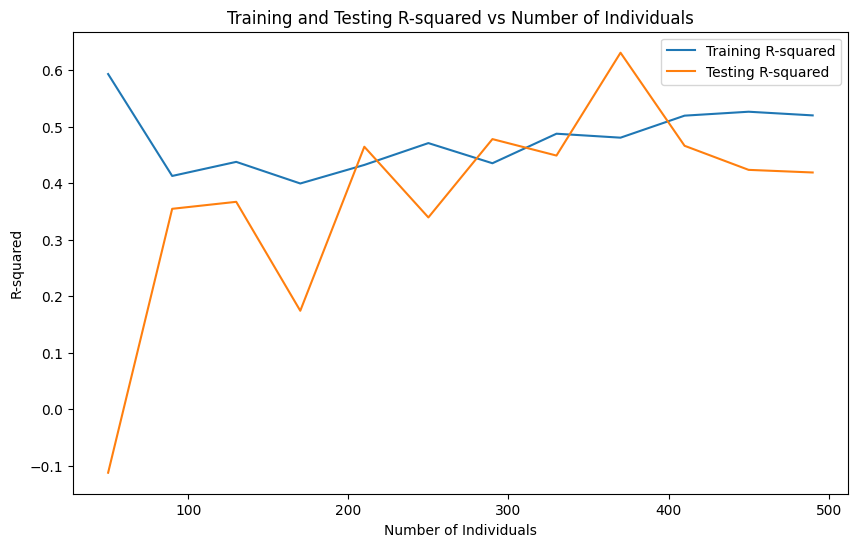

In [13]:
print("LASSO: DXA Model, Handgrip Strength (TB)")

train_test_lasso(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD'], 'tCOMB4IMaxGrip')

## DXA: Jump Power (LEGS)

LASSO: DXA Model, Jump Power (Legs)

R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.683885           0.799334
1                     450            0.713468           0.579944
2                     410            0.720116           0.632126
3                     370            0.694742           0.781030
4                     330            0.663306           0.832432
5                     290            0.700997           0.619437
6                     250            0.692046           0.687790
7                     210            0.717558           0.595530
8                     170            0.713616           0.716134
9                     130            0.702277           0.649184
10                     90            0.692767           0.675708
11                     50            0.678287           0.775714


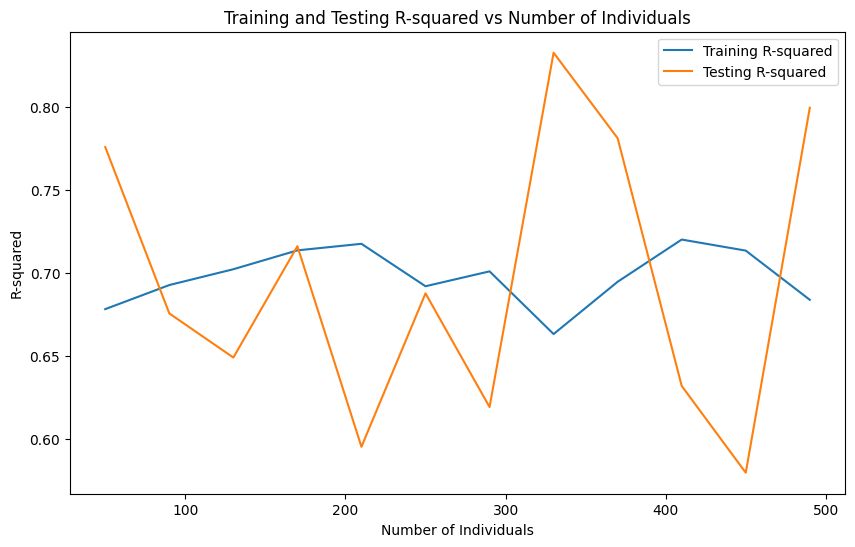

In [14]:
print("LASSO: DXA Model, Jump Power (Legs)")

train_test_lasso(df, ['COMB4ILLM', 'COMB4DLBM', 'COMB4DLFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLFNMD'], 'tjumppownums')

## DXA: Jump Power (TOTAL BODY)

LASSO: DXA Model, Jump Power (TB)

R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.704315           0.795102
1                     450            0.732641           0.604472
2                     410            0.745301           0.623481
3                     370            0.724053           0.793747
4                     330            0.696839           0.828208
5                     290            0.732721           0.628991
6                     250            0.720788           0.721009
7                     210            0.748294           0.594405
8                     170            0.749996           0.708476
9                     130            0.742598           0.680912
10                     90            0.731086           0.672152
11                     50            0.741376           0.474939


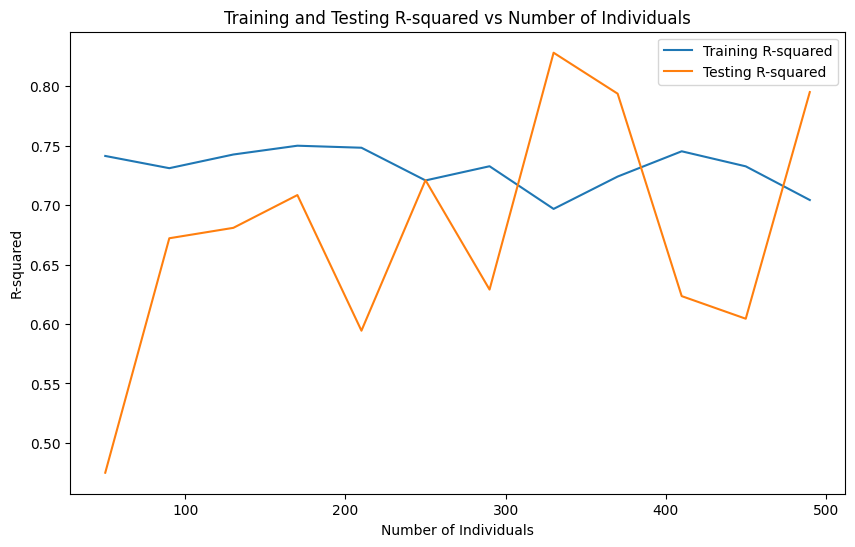

In [15]:
#DXA: Jump Power (TOTAL BODY)

print("LASSO: DXA Model, Jump Power (TB)")

train_test_lasso(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD'], 'tjumppownums')

## BIS: Handgrip Strength

LASSO: BIS Model, Handgrip Strength


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-02, tolerance: 7.713e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.649e-02, tolerance: 8.527e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.540694           0.436004
1                     450            0.554249           0.436480
2                     410            0.547166           0.480747
3                     370            0.507802           0.637149
4                     330            0.515495           0.457005
5                     290            0.480007           0.520904
6                     250            0.504532           0.392289
7                     210            0.490101           0.487488
8                     170            0.513665           0.276807
9                     130            0.524540           0.375967
10                     90            0.479161           0.580676
11                     50            0.662912          -0.128504


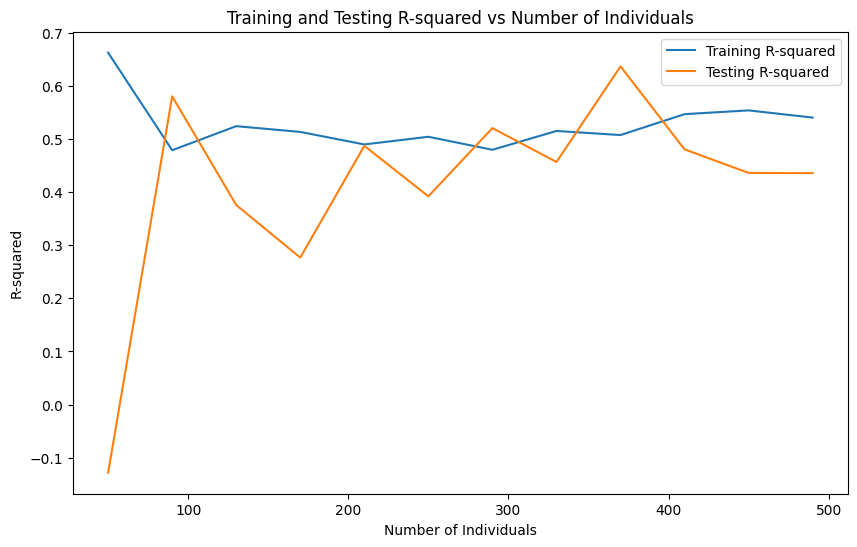

In [16]:
print("LASSO: BIS Model, Handgrip Strength")

train_test_lasso(df, ['COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A'], 'tCOMB4IMaxGrip')

## BIS: Jump Power

LASSO: BIS Model, Jump Power


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e-03, tolerance: 1.171e-03
  model = cd_fast.enet_coordinate_descent(



R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.730475           0.695925
1                     450            0.761359           0.584022
2                     410            0.771039           0.624049
3                     370            0.761035           0.761949
4                     330            0.732867           0.809999
5                     290            0.767534           0.655635
6                     250            0.779332           0.616186
7                     210            0.787360           0.720270
8                     170            0.784168           0.769438
9                     130            0.782662           0.643129
10                     90            0.774276           0.700489
11                     50            0.861065           0.260400


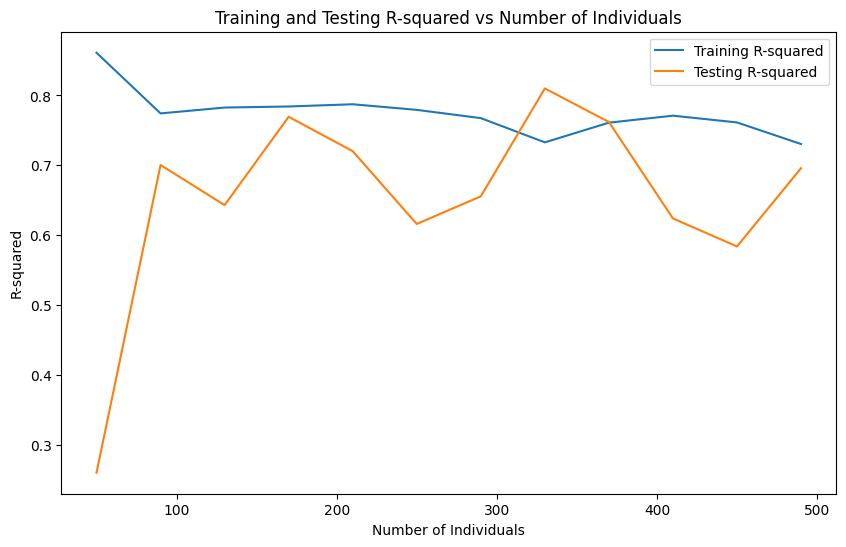

In [17]:
print("LASSO: BIS Model, Jump Power")

train_test_lasso(df, ['COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A'], 'tjumppownums')

## COMBO: Handgrip Strength (ARMS)

LASSO: Combo Models, Handgrip Strength (Arms)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.465e-02, tolerance: 2.801e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.867e-02, tolerance: 2.801e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.550579           0.415615
1                     450            0.563021           0.425791
2                     410            0.550413           0.489986
3                     370            0.518300           0.624457
4                     330            0.520905           0.469633
5                     290            0.511532           0.471783
6                     250            0.559140           0.252100
7                     210            0.523744           0.522473
8                     170            0.538002           0.338486
9                     130            0.591117           0.181175
10                     90            0.437480           0.546938
11                     50            0.533177           0.118278


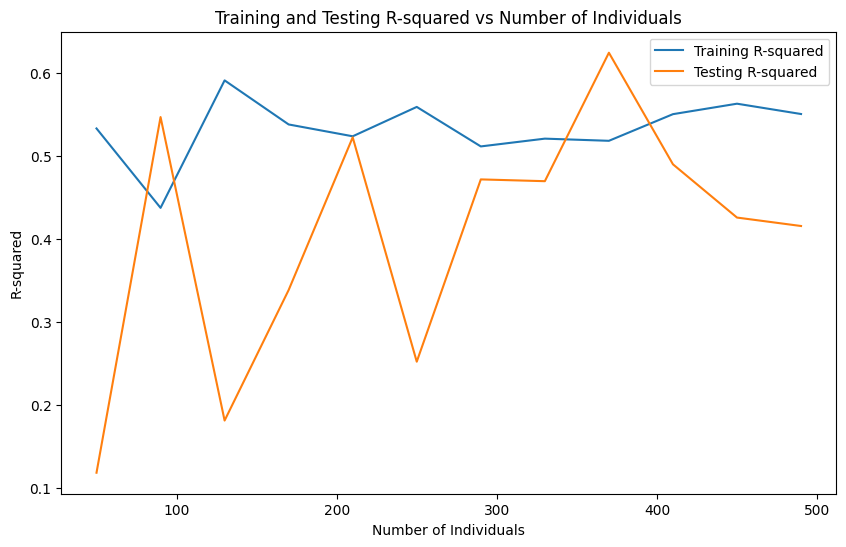

In [18]:
print("LASSO: Combo Models, Handgrip Strength (Arms)")

train_test_lasso(df, ['COMB4DALM', 'COMB4DABM', 'COMB4DAFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tCOMB4IMaxGrip')

## COMBO: Handgrip Strength (TOTAL BODY)

LASSO: Combo Models, Handgrip Strength (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e-01, tolerance: 8.527e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-02, tolerance: 6.935e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.540392           0.438414
1                     450            0.552955           0.437928
2                     410            0.542152           0.485876
3                     370            0.508311           0.637818
4                     330            0.513067           0.459414
5                     290            0.476490           0.521320
6                     250            0.505630           0.388742
7                     210            0.480924           0.486981
8                     170            0.503681           0.221915
9                     130            0.471166           0.387844
10                     90            0.483389           0.473273
11                     50            0.603882          -0.037728


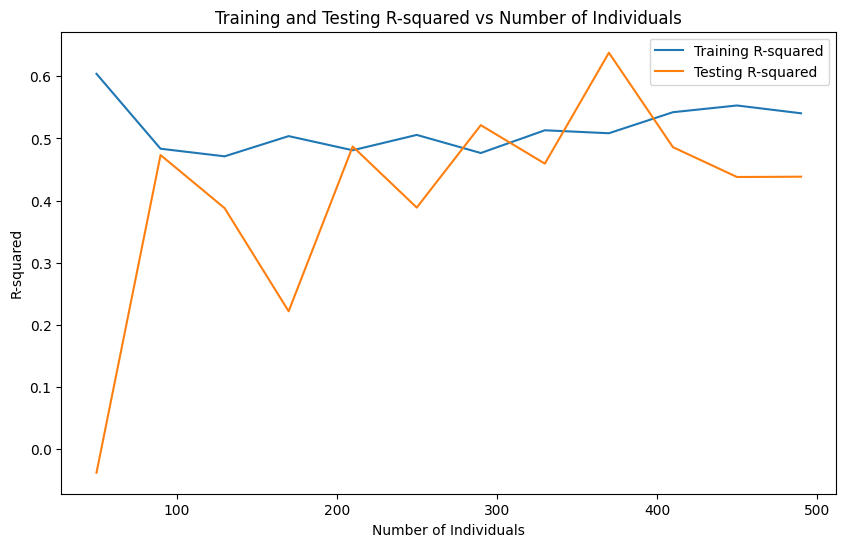

In [19]:
print("LASSO: Combo Models, Handgrip Strength (TB)")

train_test_lasso(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD', 'COMB4IMECF', 'COMB4IMICF','COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tCOMB4IMaxGrip')

## COMBO: Jump Power (LEGS)

LASSO: Combo Models, Jump Power (Legs)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.529e-04, tolerance: 5.636e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.655e-04, tolerance: 5.636e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.746604           0.724510
1                     450            0.773512           0.628351
2                     410            0.781660           0.655078
3                     370            0.773369           0.774596
4                     330            0.745945           0.833191
5                     290            0.746740           0.673966
6                     250            0.788172           0.632562
7                     210            0.776577           0.649811
8                     170            0.772260           0.756784
9                     130            0.763141           0.735448
10                     90            0.779779           0.765784
11                     50            0.856963           0.490667


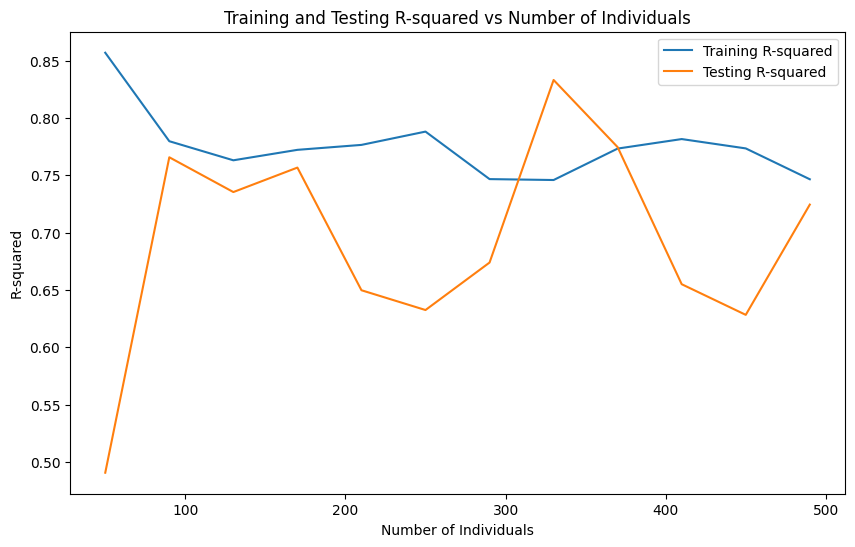

In [20]:
print("LASSO: Combo Models, Jump Power (Legs)")

train_test_lasso(df, ['COMB4ILLM', 'COMB4DLBM', 'COMB4DLFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLFNMD', 'COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tjumppownums')

## COMBO: Jump Power (TOTAL BODY)

LASSO: Combo Models, Jump Power (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e-02, tolerance: 5.636e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e-02, tolerance: 5.636e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.758513           0.741246
1                     450            0.783629           0.650237
2                     410            0.794556           0.659440
3                     370            0.786567           0.793994
4                     330            0.760727           0.838656
5                     290            0.789762           0.707906
6                     250            0.799315           0.653485
7                     210            0.793040           0.651587
8                     170            0.792550           0.775165
9                     130            0.787994           0.741208
10                     90            0.787417           0.796099
11                     50            0.856235           0.394499


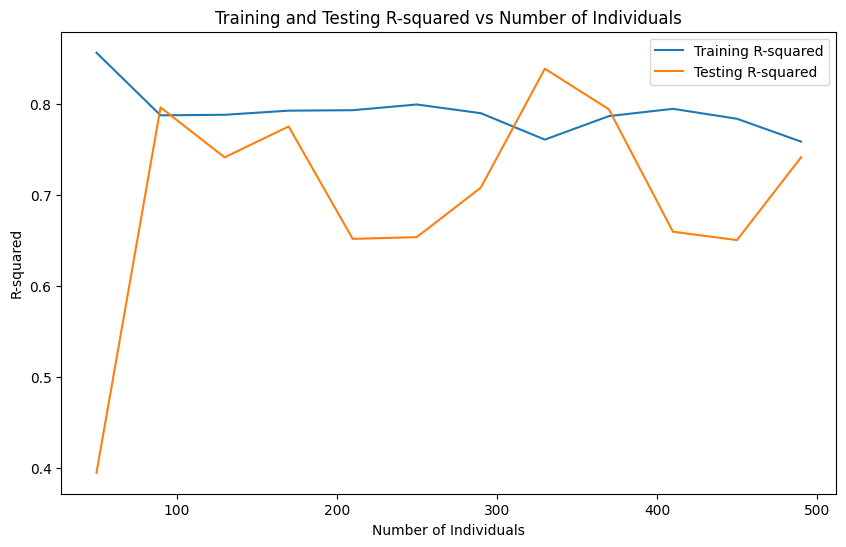

In [21]:
print("LASSO: Combo Models, Jump Power (TB)")

train_test_lasso(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD', 'COMB4IMECF', 'COMB4IMICF','COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tjumppownums')